In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
!pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df=pd.read_csv('/content/Predict Price of Airline Tickets.csv')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df.duplicated().value_counts()
print(f'shape before drop = {df.shape}')
df.drop_duplicates(inplace=True)
print(f'shape after drop = {df.shape}')

shape before drop = (10683, 11)
shape after drop = (10463, 11)


In [ ]:
##lets convert dates to months and days maybe that helps us in EDA
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], errors='coerce')
df['day']=df['Date_of_Journey'].dt.weekday
day_label={0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
df['week_day']=df['day'].map(day_label)
##
df['months']=pd.DatetimeIndex(df['Date_of_Journey']).month
month_label = {1.0: 'Jan', 2.0: 'Feb', 3.0: 'Mar', 4.0: 'April', 5.0: 'May', 6.0: 'June', 7.0: 'July', 8.0: 'Aug', 9.0: 'Sep',
      10.0: 'Oct', 11.0: 'Nov', 12.0: 'Dec' }
df['month_name']=df['months'].map(month_label)
df['year']=pd.DatetimeIndex(df['Date_of_Journey']).year     

In [ ]:
##Convert price values to categories
df=df.assign(Class=pd.cut(df['Price'],
                       bins=[0,5224,13000,20000,30000,45000,60000,80000],
                       labels=['F','E','D','C','B','A','VIP']))

In [ ]:
df['dep_hour']=pd.to_datetime(df['Dep_Time']).dt.hour
df['dep_min']=pd.to_datetime(df['Dep_Time']).dt.minute
df['arrive_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour
df['arrive_min']=pd.to_datetime(df['Arrival_Time']).dt.minute

In [ ]:
##convert duration time to numerical values
arr=list(df['Duration'])
def Duration(arr):
  for i in range(len(arr)):
    if arr[i].split()!=0:
      if 'h' in arr[i]:
        arr[i]=arr[i].strip()+'0m'
      else:
        arr[i]='0h'+arr[i]
  global dur_hrs,dur_min      
  dur_hrs,dur_min=[],[]
  for i in range(len(arr)):
    dur_hrs.append(arr[i].split(sep='h')[0]) 
    dur_min.append(arr[i].split(sep='m')[0].split()[-1])       

In [ ]:
Duration(arr)
df['dur_hrs']=dur_hrs
df['dur_min']=dur_min

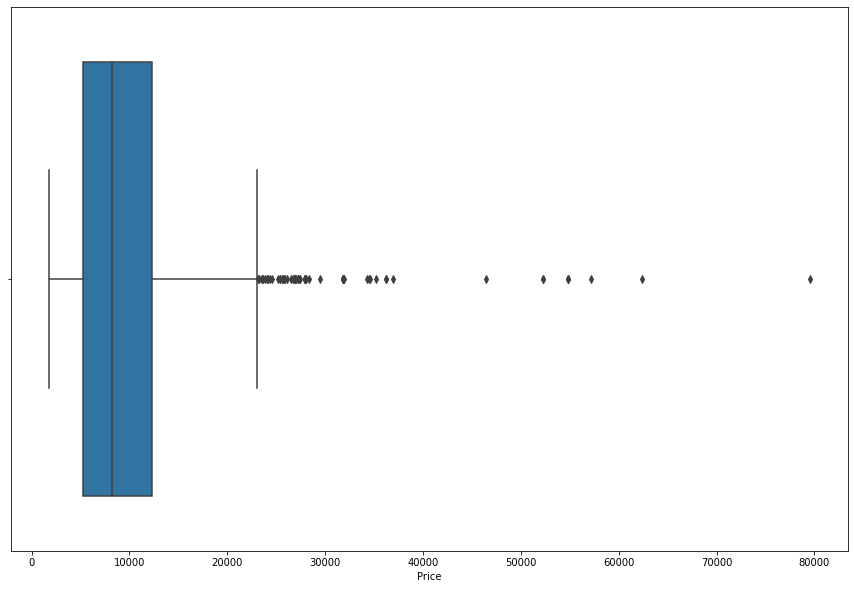

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x=df['Price'])

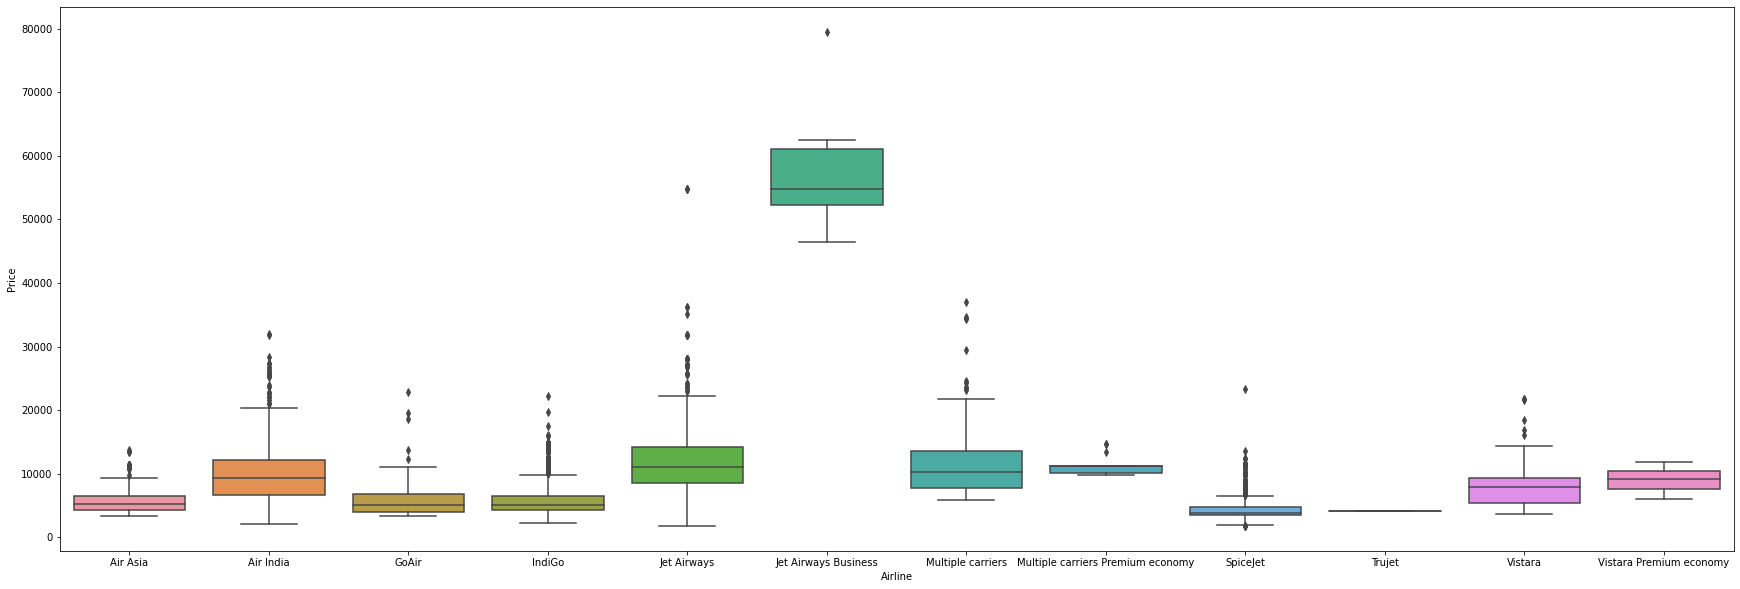

In [ ]:
##Jet airways bussiness is very more expensive
##We see that jet airways is expensive then multiple carriers then air india
plt.figure(figsize=(30,10))
sns.boxplot(x=df['Airline'],y=df['Price'],order=df.groupby(df['Airline'])['Price'].mean().index)

In [ ]:
df['Airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1695
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,months,month_name,year,Class,dep_hour,dep_min,arrive_hour,arrive_min,dur_hrs,dur_min
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,3,Mar,2019,F,22,20,1,10,2,50
1,Air India,2019-01-05,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,...,1,Jan,2019,E,5,50,13,15,7,25
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,9,Sep,2019,D,9,25,4,25,19,19h0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,...,12,Dec,2019,E,18,5,23,30,5,25
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,...,1,Jan,2019,D,16,50,21,35,4,45


In [ ]:
df.describe()

,Price,day,months,year,dep_hour,dep_min,arrive_hour,arrive_min
count,10463.000000,10463.000000,10463.000000,10463.0,10463.000000,10463.000000,10463.000000,10463.000000
mean,9026.642454,2.890567,5.534646,2019.0,12.478161,24.406958,13.387269,24.719966
std,4624.653227,1.832962,2.995204,0.0,5.727055,18.815897,6.855353,16.569658
min,1759.000000,0.000000,1.000000,2019.0,0.000000,0.000000,0.000000,0.000000
25%,5224.000000,1.000000,3.000000,2019.0,8.000000,5.000000,8.000000,10.000000
50%,8266.000000,3.000000,5.000000,2019.0,11.000000,25.000000,14.000000,25.000000
75%,12343.500000,4.000000,6.000000,2019.0,18.000000,40.000000,19.000000,35.000000
max,79512.000000,6.000000,12.000000,2019.0,23.000000,55.000000,23.000000,55.000000


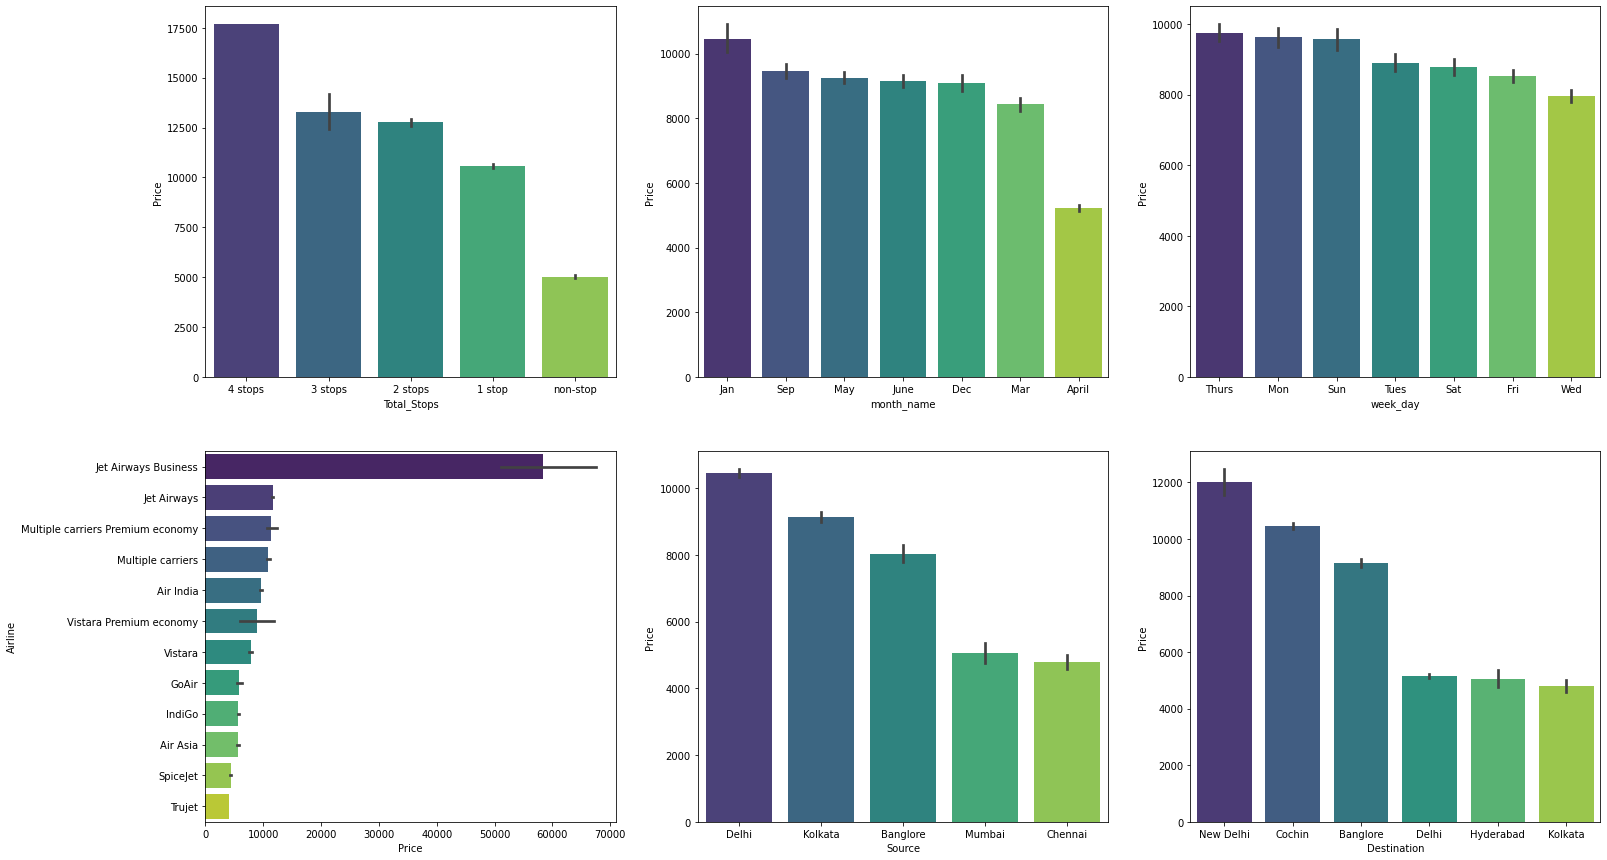

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(25,15))
sns.barplot(x=df['Total_Stops'],y=df['Price'],order=df.groupby(df['Total_Stops'])['Price'].mean().sort_values(ascending=False).index,ax=ax[0,0],palette='viridis')
sns.barplot(y=df['Airline'],x=df['Price'],ax=ax[1,0],order=df.groupby(df['Airline'])['Price'].mean().sort_values(ascending=False).index,data=df,palette='viridis')
sns.barplot(x=df['month_name'],y=df['Price'],ax=ax[0,1],order=df.groupby(df['month_name'])['Price'].mean().sort_values(ascending=False).index,data=df,palette='viridis')
sns.barplot(x=df['week_day'],y=df['Price'],ax=ax[0,2],order=df.groupby(df['week_day'])['Price'].mean().sort_values(ascending=False).index,data=df,palette='viridis')
sns.barplot(x=df['Source'],y=df['Price'],ax=ax[1,1],order=df.groupby(df['Source'])['Price'].mean().sort_values(ascending=False).index,data=df,palette='viridis')
sns.barplot(x=df['Destination'],y=df['Price'],ax=ax[1,2],order=df.groupby(df['Destination'])['Price'].mean().sort_values(ascending=False).index,data=df,palette='viridis')
####
#the most expeensive trips were booked in January
#Expensive trips were booked to "New Delhi"


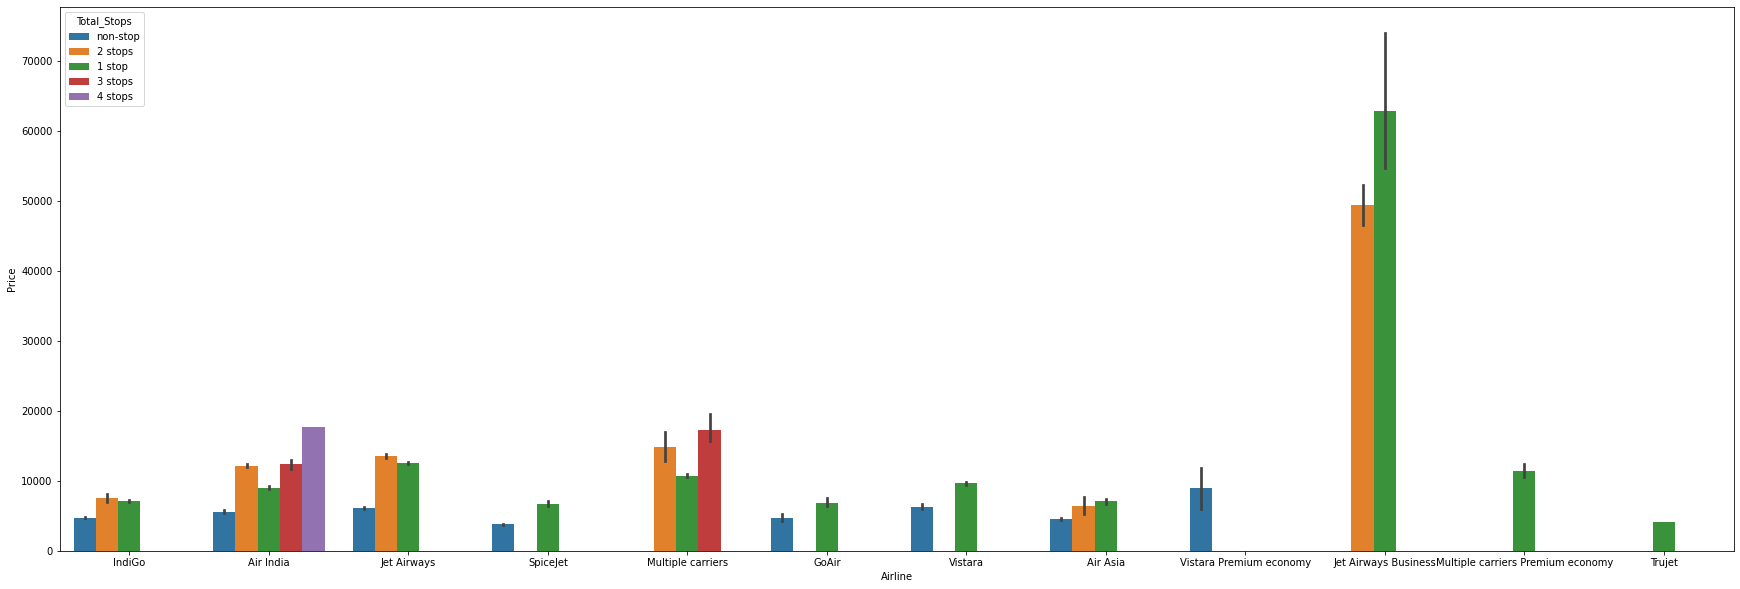

In [ ]:
#in some airlines somtimes by dec the number of stops the price increase that depends on the month of booking and the airline company and the class of the ticket
plt.figure(figsize=(30,10))
sns.barplot(x=df['Airline'],y=df['Price'],hue=df['Total_Stops'])

In [ ]:
df.groupby(df['Total_Stops'])['Price'].sum()

Total_Stops
1 stop      59591945
2 stops     16819129
3 stops       570209
4 stops        17686
non-stop    17439311
Name: Price, dtype: int64

In [ ]:
##This is JetAirways business class trips as we see the number of stops doesnt really matter
df[df['Airline']=='Jet Airways Business']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,week_day,months,month_name,year,Class
657,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? BOM ? DEL,05:45,10:45,5h,1 stop,No info,52229,3,Thurs,1,Jan,2019,A
2924,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? BOM ? DEL,05:45,11:25,5h 40m,1 stop,Business class,79512,3,Thurs,1,Jan,2019,VIP
5372,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? BOM ? DEL,05:45,12:25,6h 40m,1 stop,Business class,62427,3,Thurs,1,Jan,2019,VIP
7351,Jet Airways Business,2019-03-03,Delhi,Cochin,DEL ? ATQ ? BOM ? COK,20:05,04:25 04 Mar,8h 20m,2 stops,No info,46490,6,Sun,3,Mar,2019,A
9715,Jet Airways Business,2019-06-03,Delhi,Cochin,DEL ? ATQ ? BOM ? COK,20:05,04:25 07 Mar,8h 20m,2 stops,No info,52285,0,Mon,6,June,2019,A
10364,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? MAA ? DEL,09:45,14:25,4h 40m,1 stop,Business class,57209,3,Thurs,1,Jan,2019,A


In [ ]:
###There is a huge gap between the Bussiness class in Jet Airways Business	and that of Jet Airways also u can see that all the flights are booked at the same time with equal number of stops and same destination
df[df['Additional_Info']=='Business class']

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,week_day,months,month_name,year,Class
2924,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? BOM ? DEL,05:45,11:25,5h 40m,1 stop,Business class,79512,3,Thurs,1,Jan,2019,VIP
3032,Jet Airways,2019-01-03,Banglore,New Delhi,BLR ? BDQ ? DEL,05:50,12:20,6h 30m,1 stop,Business class,28097,3,Thurs,1,Jan,2019,C
5372,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? BOM ? DEL,05:45,12:25,6h 40m,1 stop,Business class,62427,3,Thurs,1,Jan,2019,VIP
10364,Jet Airways Business,2019-01-03,Banglore,New Delhi,BLR ? MAA ? DEL,09:45,14:25,4h 40m,1 stop,Business class,57209,3,Thurs,1,Jan,2019,A


In [ ]:
df[df['Total_Stops']=='4 stops'] ## there only one trip with 4 stops

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,week_day,months,month_name,year,Class
9182,Air India,2019-01-03,Banglore,New Delhi,BLR ? CCU ? BBI ? HYD ? VGA ? DEL,05:50,11:20 02 Mar,29h 30m,4 stops,Change airports,17686,3,Thurs,1,Jan,2019,D


In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,week_day,months,month_name,year,Class
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,6,Sun,3,Mar,2019,F
1,Air India,2019-01-05,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,Sat,1,Jan,2019,E
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,4,Fri,9,Sep,2019,D
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,3,Thurs,12,Dec,2019,E
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,3,Thurs,1,Jan,2019,D


[Text(0.5, 1.0, 'Count of month_name')]

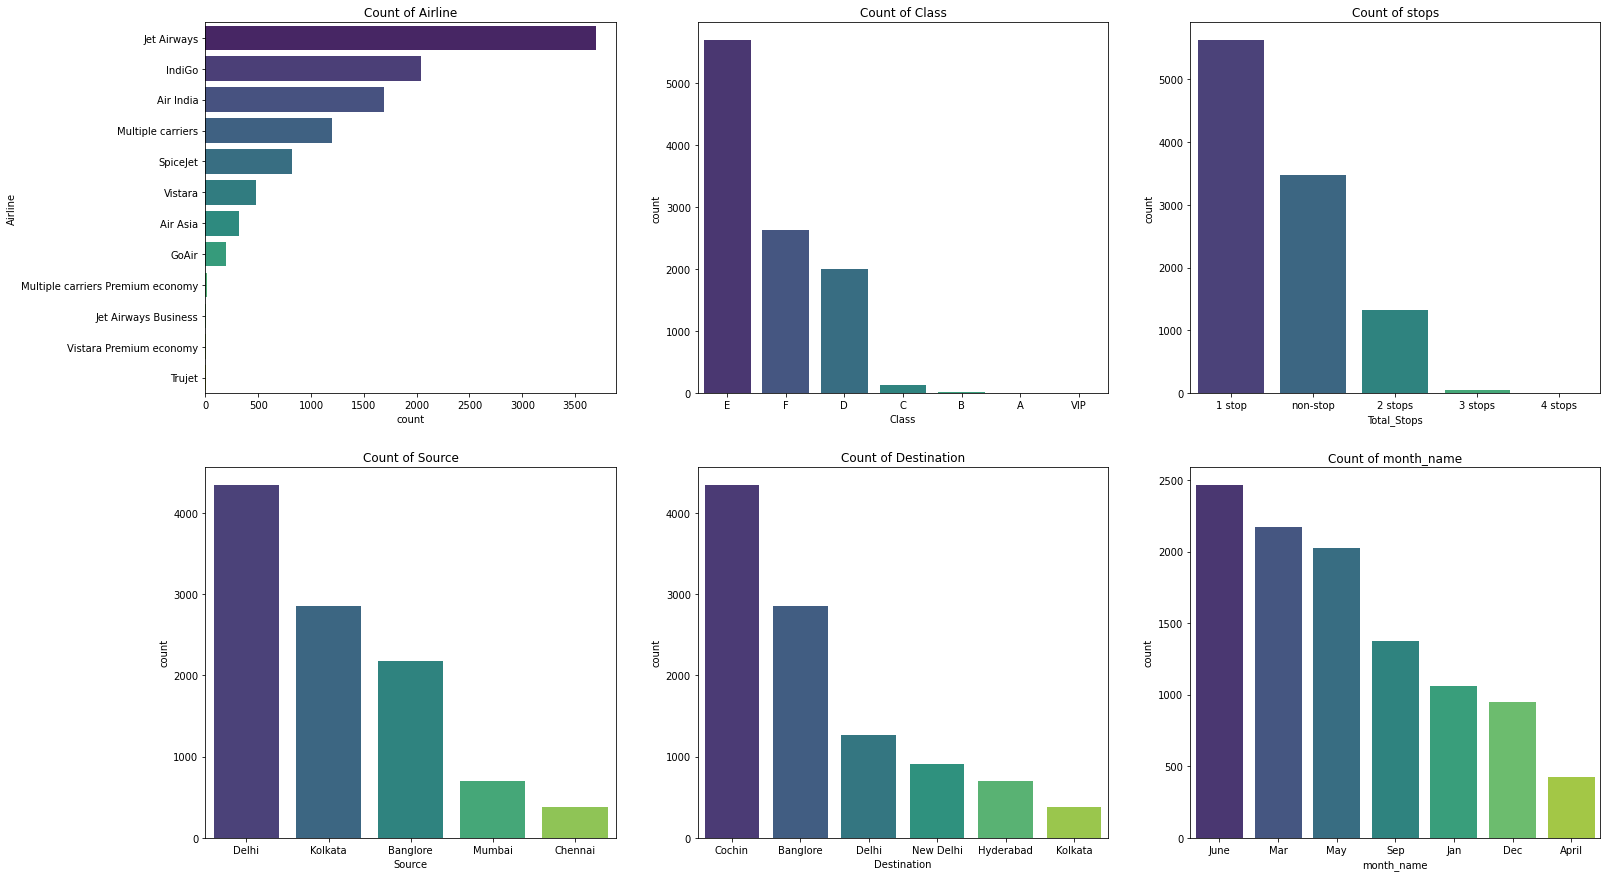

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(25,15))
sns.countplot(y=df['Airline'],ax=ax[0,0],order=df['Airline'].value_counts().index,palette='viridis').set(title='Count of Airline')
sns.countplot(x=df['Class'],ax=ax[0,1],order=df['Class'].value_counts().index,palette='viridis').set(title='Count of Class')
sns.countplot(x=df['Total_Stops'],ax=ax[0,2],order=df['Total_Stops'].value_counts().index,palette='viridis').set(title='Count of stops')
sns.countplot(x=df['Source'],ax=ax[1,0],order=df['Source'].value_counts().index,palette='viridis').set(title='Count of Source')
sns.countplot(x=df['Destination'],ax=ax[1,1],order=df['Destination'].value_counts().index,palette='viridis').set(title='Count of Destination')
sns.countplot(x=df['month_name'],ax=ax[1,2],order=df['month_name'].value_counts().index,palette='viridis').set(title='Count of month_name')
#################
#JetAirways has the highest number of flights that explains why the are expensive
#most of the trips where booked 1stop
#we see that June is a very busy months while April has the lowiest number of flights
#April has the lowest number of flights

[Text(0.5, 1.0, 'counts of flights')]

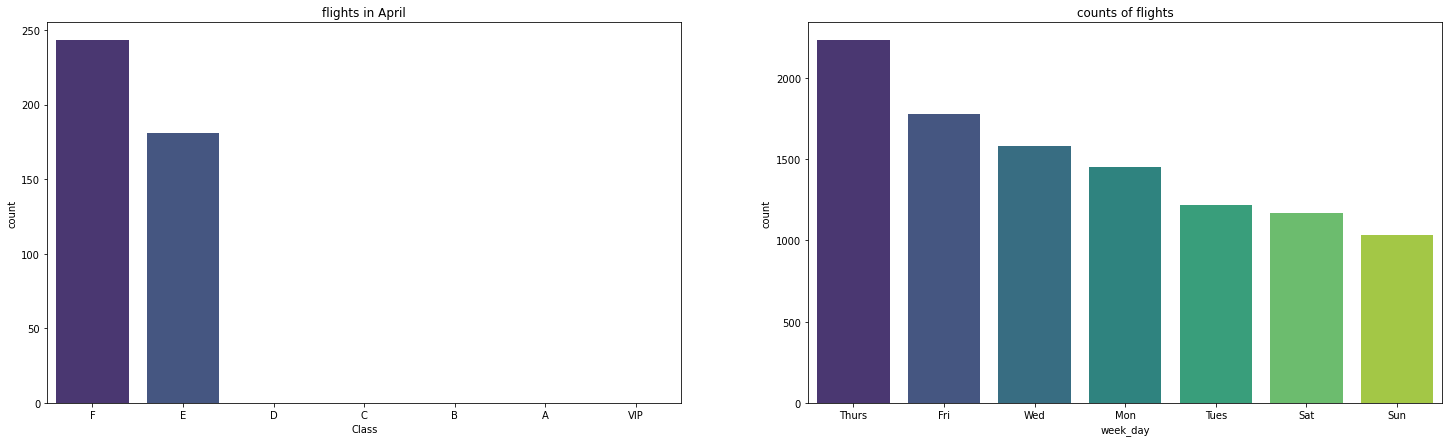

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(25,7))
sns.countplot(x=df[df['month_name']=='April']['Class'],palette='viridis',ax=ax[0]).set(title='flights in April')
sns.countplot(x=df['week_day'],order=df['week_day'].value_counts().index,palette='viridis',ax=ax[1]).set(title='counts of flights')
##flights booked in April were mostly in categgory F and E 'low price'

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
x_df=df.apply(le.fit_transform)
x_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,months,month_name,year,Class,dep_hour,dep_min,arrive_hour,arrive_min,dur_hrs,dur_min
0,3,11,0,5,18,211,233,240,4,8,...,1,4,0,5,22,4,1,2,12,34
1,1,2,3,0,84,31,906,336,1,8,...,0,2,0,4,5,10,13,3,41,18
2,4,35,2,1,118,70,413,106,1,8,...,5,6,0,3,9,5,4,5,11,11
3,3,38,3,0,91,164,1324,311,0,8,...,6,1,0,4,18,1,23,6,39,18
4,3,0,0,5,29,149,1237,303,0,8,...,0,2,0,3,16,10,21,7,34,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,33,3,0,64,183,1259,236,4,8,...,5,6,0,5,19,11,22,5,12,23
10679,1,17,3,0,64,193,1305,237,4,8,...,2,0,0,5,20,9,23,4,12,26
10680,4,17,0,2,18,58,824,280,4,8,...,2,0,0,4,8,4,11,4,23,28
10681,10,0,0,5,18,92,938,238,4,8,...,0,2,0,4,11,6,14,2,12,29


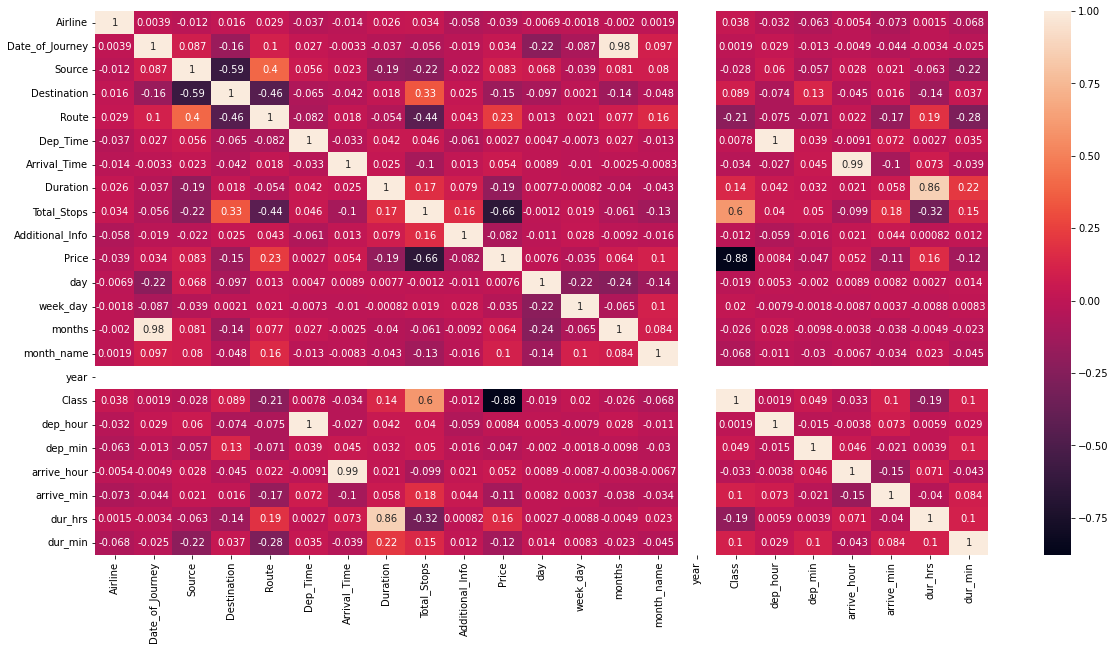

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(x_df.corr(),annot=True)

In [ ]:
from sklearn.model_selection import train_test_split
x=x_df[['month_name','Total_Stops','Duration','Route','Destination','dur_hrs']]
y=x_df['Price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(x_train,y_train)

DecisionTreeRegressor()

In [ ]:
from sklearn import tree
columns=['month_name', 'Total_Stops', 'Duration', 'Route', 'Destination',
       'dur_hrs']
#print(tree.export_text(dt, feature_names=columns))

In [ ]:
import graphviz
#dot_data=tree.export_graphviz(dt,out_file=None,feature_names=columns,filled=True)
#graph=graphviz.Source(dot_data,format='png')
#graph

In [ ]:
from sklearn import metrics
y_pred=dt.predict(x_test)
print('mean squared error = ',metrics.mean_squared_error(y_pred,y_test))
print('mean Absolute error = ',metrics.mean_absolute_error(y_pred,y_test))
print('R2_score = ',metrics.r2_score(y_pred,y_test))

mean squared error =  117318.40239877815
mean Absolute error =  241.25409282189196
R2_score =  0.5785176096931888


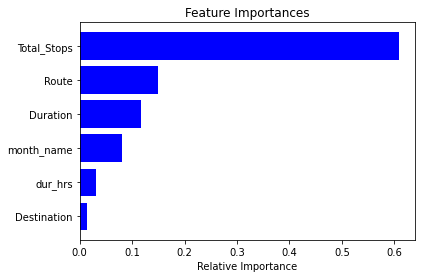

In [ ]:
importances = dt.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align='center')
plt.yticks(range(len(indices)),[columns[i] for i in indices ])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
x=x_df[['month_name','Total_Stops','Duration','Route','Destination','Class','dur_hrs']].values
y=x_df['Price'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

In [ ]:
#Best fitting for this data is Random forest
y_pred2=rf.predict(x_test)
MAE=metrics.mean_absolute_error(y_pred2,y_test)
MSE=metrics.mean_squared_error(y_pred2,y_test)
RMSE=np.sqrt(MSE)
R2_score=metrics.r2_score(y_pred2,y_test)

print(' mean_absolute_error= ', MAE)
print(' mean_squared_error= ', MSE)
print(' Root mean_squared_error= ', RMSE)
print(' R2_score= ', R2_score)

 mean_absolute_error=  118.10274913150197
 mean_squared_error=  35150.50300502528
 Root mean_squared_error=  187.4846740537084
 R2_score=  0.8826920315193514


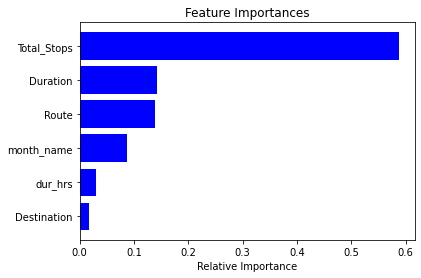

In [ ]:
importances = rf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'b', align='center')
plt.yticks(range(len(indices)),[columns[i] for i in indices ])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
x=x_df[['month_name','Total_Stops','Duration','Route','Class','dur_hrs','Destination']].values
y=x_df['Price'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=42)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly_reg=PolynomialFeatures(degree=5)
poly_reg.fit_transform(x)
##
lin_reg=linear_model.LinearRegression()
lin_reg.fit(x_train,y_train)
##
y_pred3=lin_reg.predict(x_test)
avg_loss,bias,variance=bias_variance_decomp(lin_reg,x_train,y_train,x_test,y_test,loss='mse',random_seed=32,num_rounds=200)
##
MAE=metrics.mean_absolute_error(y_pred3,y_test)
MSE=metrics.mean_squared_error(y_pred3,y_test)
RMSE=np.sqrt(MSE)
R2_score=metrics.r2_score(y_pred3,y_test)

print(' mean_absolute_error= ', MAE)
print(' mean_squared_error= ', MSE)
print(' Root mean_squared_error= ', RMSE)
print(' R2_score= ', R2_score)
###
print('Average Loss = ', round(avg_loss,4))
print('Average bais = ', round(bias,4))
print('Average variance = ', round(variance,4))


 mean_absolute_error=  187.40306035673817
 mean_squared_error=  62418.2602832327
 Root mean_squared_error=  249.83646708043383
 R2_score=  0.7550108163621428
Average Loss =  62507.1903
Average bais =  62421.8871
Average variance =  85.3032
